# Exploring Dandiset 001195: Separable Dorsal Raphe Dopamine Projections Mediate the Facets of Loneliness-like State

> **Warning**: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results.

## Overview

[Dandiset 001195](https://dandiarchive.org/dandiset/001195) contains a rich collection of data supporting research on the role of dorsal raphe dopamine neurons in social isolation and loneliness-like states in mice. The dataset includes both intracellular electrophysiology recordings (patch-clamp) and in vivo calcium imaging with behavioral videos.

This notebook will demonstrate how to access and analyze both types of data from this Dandiset, focusing on:

1. Loading and exploring the dataset metadata
2. Working with intracellular electrophysiology recordings from the Dorsal Raphe Nucleus (DRN)
3. Analyzing calcium imaging data from the Central Amygdala (CeA)
4. Visualizing neuronal responses to different stimuli

These analyses will help to understand how these neural circuits may contribute to social behaviors and responses to social isolation.

## Required Packages

The following packages are required to run this notebook:

- `pynwb` - For reading and working with Neurodata Without Borders (NWB) files
- `matplotlib` - For data visualization
- `numpy` - For numerical operations
- `remfile` - For remote file access
- `h5py` - For handling HDF5 files
- `dandi` - For interacting with the DANDI archive
- `pandas` - For data manipulation
- `seaborn` - For enhanced visualization

In [1]:
# Import required packages
import dandi.dandiapi as dandi
import matplotlib.pyplot as plt
import numpy as np
import h5py
import remfile
import pynwb
import pandas as pd
import seaborn as sns

# Set up plotting style
sns.set_theme()
plt.rcParams['figure.figsize'] = (12, 6)

## Connecting to the DANDI Archive and Exploring the Dandiset

In [2]:
# Connect to DANDI Archive
client = dandi.DandiAPIClient()
dandiset = client.get_dandiset("001195")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: https://dandiarchive.org/dandiset/001195")

Dandiset name: Separable Dorsal Raphe Dopamine Projections Mediate the Facets of Loneliness-like State
Dandiset URL: https://dandiarchive.org/dandiset/001195


### Exploring the Dandiset Metadata

In [3]:
# Display more detailed information
print(f"Description: {metadata['description'][:500]}...")
print("\nKeywords:")
for keyword in metadata['keywords']:
    print(f"- {keyword}")

print("\nAnatomical regions studied:")
for anatomy in metadata['about']:
    if anatomy.get('schemaKey') == 'Anatomy':
        print(f"- {anatomy['name']} ({anatomy['identifier']})")

print("\nMeasurement techniques:")
if 'measurementTechnique' in metadata:
    for technique in metadata['measurementTechnique']:
        print(f"- {technique['name']}")
else:
    print("- Measurement technique information not available")

Description: Supporting data for the publication "Separable Dorsal Raphe Dopamine Projections Mediate the Facets of Loneliness-like State" by Christopher R. Lee, Gillian A. Matthews, Mackenzie E. Lemieux, Elizabeth M. Wasserlein, Matilde Borio, Raymundo L. Miranda, Laurel R. Keyes, Gates P. Schneider, Caroline Jia, Andrea Tran, Faith Aloboudi, May G. Chan, Enzo Peroni, Grace S. Pereira, Alba López-Moraga, Anna Pallé, Eyal Y. Kimchi, Nancy Padilla-Coreano, Romy Wichmann, Kay M. Tye.  bioRxiv 2025.02.03.636224...

Keywords:
- optogenetics
- behavior videos
- calcium imaging
- electrophysiology
- Social Isolation
- Social Motivation
- mouse behavior
- behavioral neuroscience
- mouse model
- Dorsal Raphe Nucleus (DRN)
- Dopamine neurons

Anatomical regions studied:
- dorsal raphe nucleus (DRN) (UBERON:0001950)
- Central Amygdala (CeA) (UBERON:0001876)
- Bed Nucleus of the Stria Terminalis (BNST) (UBERON:0001880)
- Posterior Basolateral Amygdala (BLP) (UBERON:0006107)

Measurement technique

### List the Assets in the Dandiset 

In [4]:
# List the assets in the Dandiset
assets = list(dandiset.get_assets())
print(f"\nFound {len(assets)} assets in the dataset")

# Filter assets by type to separate electrophysiology from imaging data
icephys_assets = [asset for asset in assets if 'icephys.nwb' in asset.path]
imaging_assets = [asset for asset in assets if 'image+ophys' in asset.path]

print(f"\nElectrophysiology recordings: {len(icephys_assets)}")
print(f"Calcium imaging recordings: {len(imaging_assets)}")

# Display a few examples of each type
print("\nSample electrophysiology files:")
for asset in icephys_assets[:3]:
    print(f"- {asset.path} ({asset.size / 1e6:.1f} MB)")

print("\nSample calcium imaging files:")
for asset in imaging_assets[:3]:
    print(f"- {asset.path} ({asset.size / 1e6:.1f} MB)")


Found 230 assets in the dataset

Electrophysiology recordings: 148
Calcium imaging recordings: 82

Sample electrophysiology files:
- sub-23/sub-23_ses-20150324T134114_slice-slice-1_cell-C1_icephys.nwb (37.7 MB)
- sub-23/sub-23_ses-20150324T161217_slice-slice-2_cell-B3_icephys.nwb (39.7 MB)
- sub-235/sub-235_ses-20200921T142415_slice-slice-1_cell-C3_icephys.nwb (13.6 MB)

Sample calcium imaging files:
- sub-C370/sub-C370_ses-20230302T183851_image+ophys/4b53f4c6-119c-4f5f-a580-d3d8040ae3f0_external_file_0.mp4 (140.5 MB)
- sub-C370/sub-C370_ses-20230312T162000_image+ophys/9967e37f-3fdd-4c30-b689-4eeccfe108f6_external_file_0.mp4 (148.0 MB)
- sub-C386/sub-C386_ses-20230228T172437_image+ophys/63380007-ec56-4e61-ac77-0044ebe65f1b_external_file_0.mp4 (159.0 MB)


## Intracellular Electrophysiology Data

First, we'll look at the intracellular electrophysiology recordings. These are patch-clamp recordings from neurons in the Dorsal Raphe Nucleus, which is the area where dopamine neurons that project to different brain regions are located.

### Loading an Electrophysiology NWB File

In [5]:
# Select an electrophysiology file to analyze
icephys_file_url = "https://api.dandiarchive.org/api/assets/a243dde4-c270-42a9-8550-025f5ffcd5a7/download/"
print(f"Loading electrophysiology file from URL: {icephys_file_url}")

# Open the remote file
remote_file = remfile.File(icephys_file_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb_icephys = io.read()

Loading electrophysiology file from URL: https://api.dandiarchive.org/api/assets/a243dde4-c270-42a9-8550-025f5ffcd5a7/download/


### Exploring the Electrophysiology File Metadata

In [6]:
# Print basic information about the recording
print(f"Session description: {nwb_icephys.session_description}")
print(f"Session start time: {nwb_icephys.session_start_time}")
print(f"Experimenter: {nwb_icephys.experimenter}")
print("\nSubject information:")
print(f"  Subject ID: {nwb_icephys.subject.subject_id}")
print(f"  Age: {nwb_icephys.subject.age}")
print(f"  Sex: {nwb_icephys.subject.sex}")
print(f"  Species: {nwb_icephys.subject.species}")
print(f"  Description: {nwb_icephys.subject.description}")

# Get information about the lab
if hasattr(nwb_icephys, 'lab_meta_data') and 'DandiIcephysMetadata' in nwb_icephys.lab_meta_data:
    metadata = nwb_icephys.lab_meta_data['DandiIcephysMetadata']
    print("\nRecording information:")
    print(f"  Cell ID: {metadata.cell_id}")
    print(f"  Slice ID: {metadata.slice_id}")
    print(f"  Targeted layer/region: {metadata.targeted_layer}")
    print(f"  Inferred layer/region: {metadata.inferred_layer}")

Session description: episodic stimulation
Session start time: 2015-03-24 13:41:14-07:00
Experimenter: ('Matthews, Gillian',)

Subject information:
  Subject ID: 23
  Age: P302D
  Sex: F
  Species: Mus musculus
  Description: AAV5-DIO-ChR2-eYFP into DRN

Recording information:
  Cell ID: C1
  Slice ID: slice 1
  Targeted layer/region: CeA
  Inferred layer/region: CeA


### Understanding the Acquisition and Stimulus Data

In [7]:
# Get a list of acquisition and stimulus data available
acquisition_keys = list(nwb_icephys.acquisition.keys())
stimulus_keys = list(nwb_icephys.stimulus.keys())

print(f"Number of acquisition series: {len(acquisition_keys)}")
print(f"Number of stimulus series: {len(stimulus_keys)}")

# Print the first few acquisition keys to understand naming pattern
print("\nSample acquisition keys:")
for key in acquisition_keys[:5]:
    print(f"- {key}")

# Print the first few stimulus keys
print("\nSample stimulus keys:")
for key in stimulus_keys[:5]:
    print(f"- {key}")

Number of acquisition series: 87
Number of stimulus series: 86

Sample acquisition keys:
- current_clamp-response-01-ch-0
- current_clamp-response-01-ch-1
- current_clamp-response-02-ch-0
- current_clamp-response-02-ch-1
- current_clamp-response-03-ch-0

Sample stimulus keys:
- stimulus-01-ch-0
- stimulus-01-ch-1
- stimulus-02-ch-0
- stimulus-02-ch-1
- stimulus-03-ch-0


### Analyzing Neuronal Responses to Current Injections

Let's examine a few current clamp recordings to see how the neurons respond to different current injections. We'll select a few recordings with different stimulus intensities.

In [8]:
# Function to extract and plot response to a specific stimulus
def plot_response(nwb_file, response_key, stimulus_key, ax=None):
    """
    Extract and plot the response to a specific stimulus.
    
    Parameters:
    -----------
    nwb_file : NWBFile
        The NWB file containing the data
    response_key : str
        The key for the response data in nwb.acquisition
    stimulus_key : str
        The key for the stimulus data in nwb.stimulus
    ax : matplotlib.axes, optional
        The axes to plot on. If None, a new figure is created.
    
    Returns:
    --------
    fig, ax : tuple
        The figure and axes objects
    """
    if ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    else:
        fig = ax[0].figure
    
    # Get response data
    response = nwb_file.acquisition[response_key].data[:]
    conversion = nwb_file.acquisition[response_key].conversion  # Convert to mV
    response_mV = response * conversion * 1000  # Convert to mV
    
    # Get stimulus data
    if stimulus_key in nwb_file.stimulus:
        stim = nwb_file.stimulus[stimulus_key].data[:] * 1e12  # Convert to pA
    else:
        stim = np.zeros_like(response)
        print(f"Stimulus key {stimulus_key} not found.")
    
    # Create time vector
    rate = nwb_file.acquisition[response_key].rate  # Hz
    t = np.arange(len(response)) / rate  # seconds
    
    # Calculate mean stimulus amplitude during the steady part
    if len(stim) > 0:
        stim_steady = stim[int(rate*0.2):int(rate*0.8)]
        mean_stim = np.mean(stim_steady) if len(stim_steady) > 0 else 0
    else:
        mean_stim = 0
    
    # Plot response
    ax[0].plot(t, response_mV)
    ax[0].set_ylabel('Membrane Potential (mV)')
    ax[0].set_title(f'Response to {mean_stim:.1f} pA')
    ax[0].grid(True)
    
    # Plot stimulus
    ax[1].plot(t, stim)
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Current (pA)')
    ax[1].set_title('Stimulus Current')
    ax[1].grid(True)
    
    plt.tight_layout()
    return fig, ax

Now let's select a few recordings with different stimulus intensities and examine the responses:

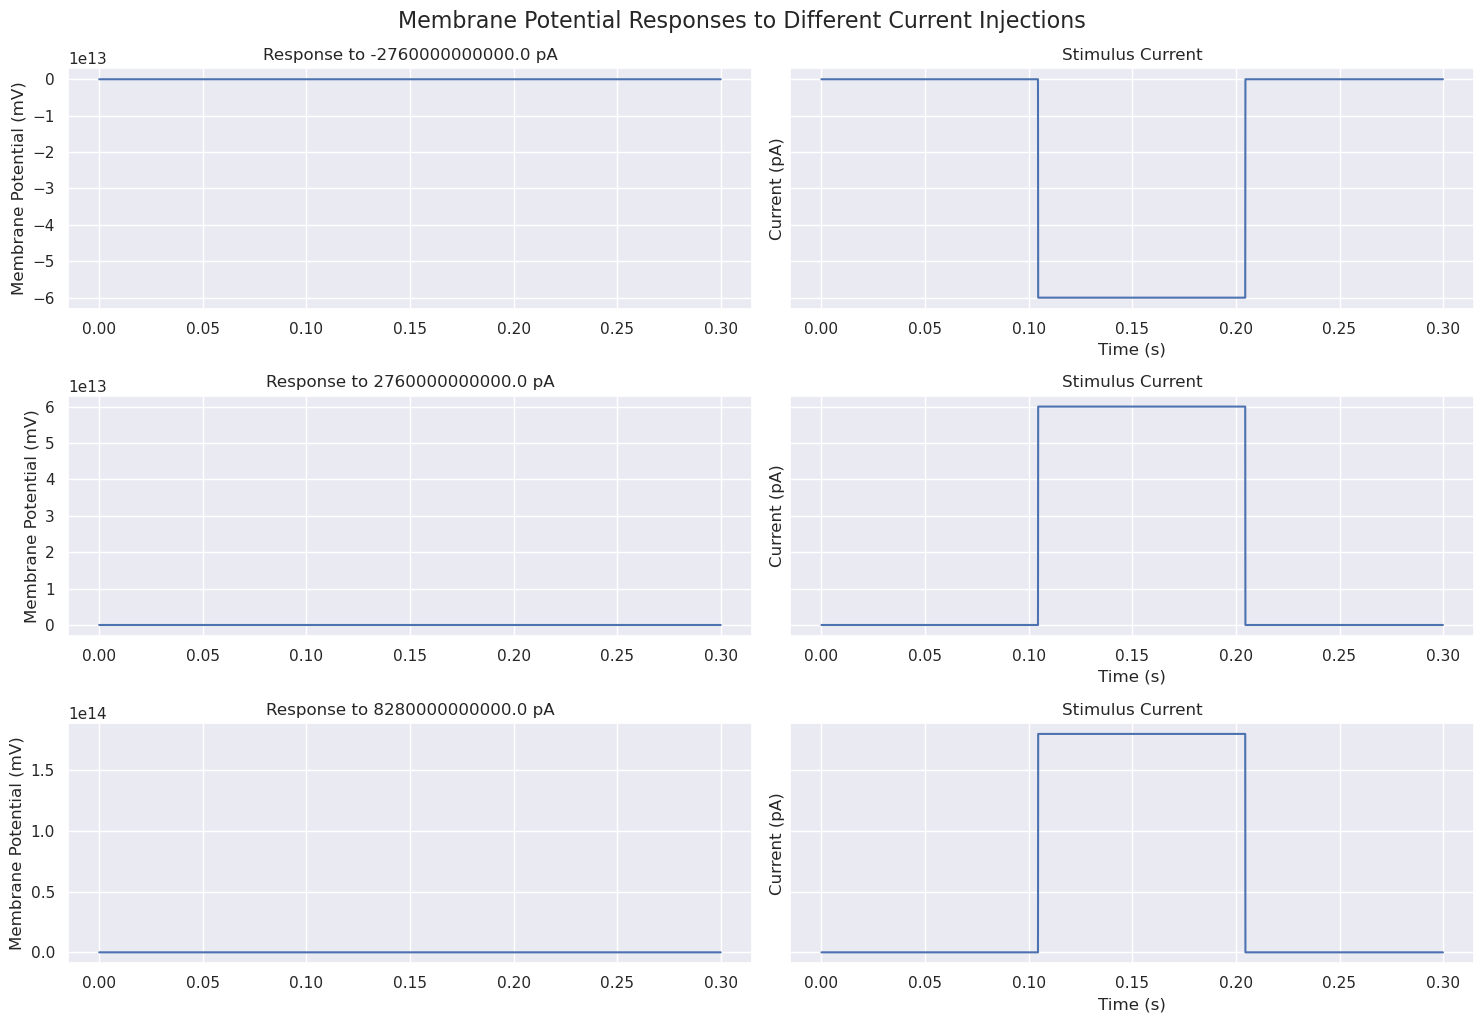

In [9]:
# Select specific stimulus intensities to examine
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharey='row')

# Select a few different stimuli with varying current levels
for i, idx in enumerate([4, 10, 16]):  # -60pA, +60pA, +180pA (example values)
    response_key = f"current_clamp-response-{idx:02d}-ch-0"
    stim_key = f"stimulus-{idx:02d}-ch-0"
    
    if response_key in nwb_icephys.acquisition and stim_key in nwb_icephys.stimulus:
        _, _ = plot_response(nwb_icephys, response_key, stim_key, [axes[i, 0], axes[i, 1]])
    else:
        print(f"Keys not found: {response_key}, {stim_key}")

plt.tight_layout()
plt.suptitle('Membrane Potential Responses to Different Current Injections', fontsize=16, y=1.02)
plt.show()

### Action Potentials in Response to Current Injection

Let's focus on a stimulus that generates action potentials to examine spiking properties:

Found action potentials in current_clamp-response-13-ch-0


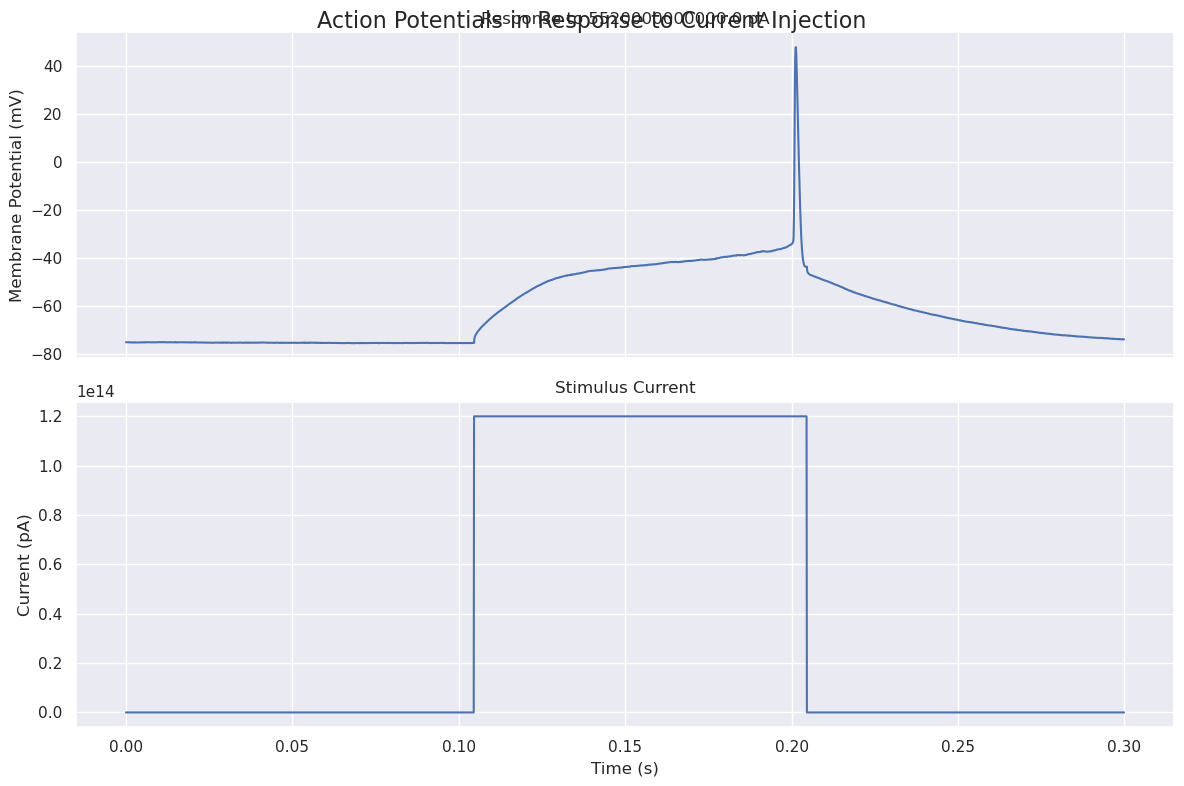

In [10]:
# Find a response with action potentials
for idx in range(1, 30):
    response_key = f"current_clamp-response-{idx:02d}-ch-0"
    stim_key = f"stimulus-{idx:02d}-ch-0"
    
    if response_key in nwb_icephys.acquisition:
        response = nwb_icephys.acquisition[response_key].data[:]
        conversion = nwb_icephys.acquisition[response_key].conversion
        response_mV = response * conversion * 1000  # Convert to mV
        
        # Check if there are likely action potentials (membrane potential exceeds 0 mV)
        if np.any(response_mV > 0):
            print(f"Found action potentials in {response_key}")
            fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
            _, _ = plot_response(nwb_icephys, response_key, stim_key, ax)
            plt.suptitle('Action Potentials in Response to Current Injection', fontsize=16)
            plt.show()
            break

### Current-Voltage Relationship

Let's analyze the current-voltage relationship by looking at the steady-state membrane potential in response to different current injections:

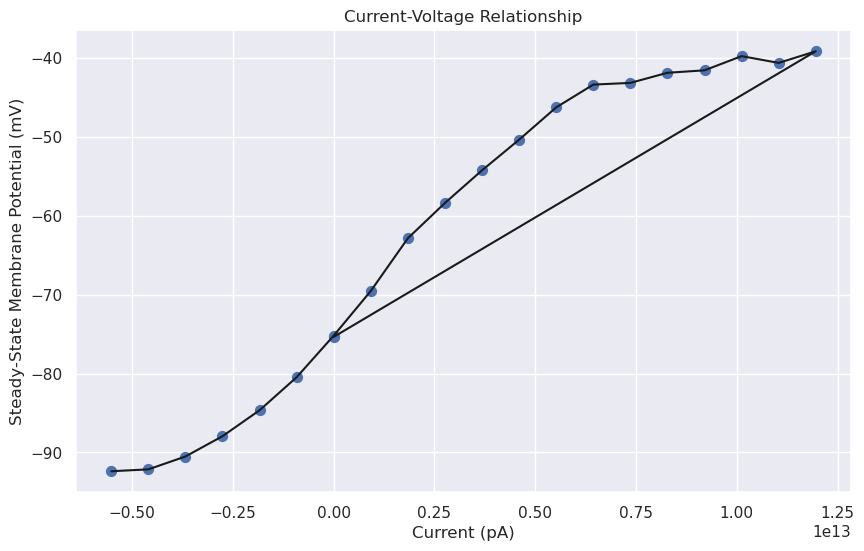

In [11]:
# Extract steady-state membrane potential for different current injections
currents = []
steady_state_voltages = []

# Iterate through stimuli
for idx in range(1, 30):  # Check a range of stimuli
    response_key = f"current_clamp-response-{idx:02d}-ch-0"
    stim_key = f"stimulus-{idx:02d}-ch-0"
    
    if response_key in nwb_icephys.acquisition and stim_key in nwb_icephys.stimulus:
        # Get stimulus current
        stim = nwb_icephys.stimulus[stim_key].data[:] * 1e12  # Convert to pA
        rate = nwb_icephys.acquisition[response_key].rate
        stim_steady = stim[int(rate*0.2):int(rate*0.8)]
        mean_stim = np.mean(stim_steady) if len(stim_steady) > 0 else 0
        
        # Get response
        response = nwb_icephys.acquisition[response_key].data[:]
        conversion = nwb_icephys.acquisition[response_key].conversion
        response_mV = response * conversion * 1000  # Convert to mV
        
        # Get steady-state voltage (avoid including action potentials)
        # Calculate steady state by taking the mean of the last 20% of the trace
        # but cap the max value to filter out action potentials
        response_steady = response_mV[int(len(response_mV)*0.5):int(len(response_mV)*0.8)]
        steady_state = np.mean(response_steady[response_steady < -20]) if len(response_steady) > 0 else np.nan
        
        if not np.isnan(steady_state):
            currents.append(mean_stim)
            steady_state_voltages.append(steady_state)

# Plot I-V curve
plt.figure(figsize=(10, 6))
plt.scatter(currents, steady_state_voltages, s=50)
plt.plot(currents, steady_state_voltages, 'k-')
plt.xlabel('Current (pA)')
plt.ylabel('Steady-State Membrane Potential (mV)')
plt.title('Current-Voltage Relationship')
plt.grid(True)
plt.show()

## Calcium Imaging Data

Now let's explore the calcium imaging data from this Dandiset. These recordings show activity in the Central Amygdala (CeA), which is one of the projection targets of the Dorsal Raphe Dopamine neurons.

### Loading a Calcium Imaging NWB File

In [12]:
# Select a calcium imaging file to analyze
calcium_file_url = "https://api.dandiarchive.org/api/assets/7ac3357c-06e4-4f04-a869-2f3a71524456/download/"
print(f"Loading calcium imaging file from URL: {calcium_file_url}")

# Open the remote file
remote_file = remfile.File(calcium_file_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb_calcium = io.read()

Loading calcium imaging file from URL: https://api.dandiarchive.org/api/assets/7ac3357c-06e4-4f04-a869-2f3a71524456/download/


### Exploring the Calcium Imaging File Metadata

In [13]:
# Print basic information about the recording
print(f"Session description: {nwb_calcium.session_description}")
print(f"Session start time: {nwb_calcium.session_start_time}")
print(f"Experimenter: {nwb_calcium.experimenter}")
print(f"Experiment description: {nwb_calcium.experiment_description}")
print(f"Stimulus notes: {nwb_calcium.stimulus_notes}")

print("\nSubject information:")
print(f"  Subject ID: {nwb_calcium.subject.subject_id}")
print(f"  Age: {nwb_calcium.subject.age}")
print(f"  Sex: {nwb_calcium.subject.sex}")
print(f"  Species: {nwb_calcium.subject.species}")
print(f"  Description: {nwb_calcium.subject.description}")

Session description: Group housed, Day 2, Stim OFF, 3/2/2023
Session start time: 2023-03-02 18:38:51+00:00
Experimenter: ('Lee, Christopher ',)
Experiment description: 5min habituation - 5min stimulation with juvenile (couterbalanced across two days) - 5min no stimulation with juvenile
Stimulus notes: 5min at 20Hz, 5ms 10mW/mm2 - 589nm

Subject information:
  Subject ID: C370
  Age: P145D
  Sex: M
  Species: Mus musculus
  Description: DRNDAT_chrimson, intermediate rank


### Exploring the Calcium Imaging Data Structure

In [14]:
# Get information about the imaging data
image_series = nwb_calcium.acquisition["OnePhotonSeries"]
print(f"Frame rate: {image_series.rate} Hz")
print(f"Image dimensions: {image_series.dimension[:]}")
print(f"Number of frames: {image_series.data.shape[0]}")

# Get information about the imaging plane
plane = image_series.imaging_plane
print(f"\nImaging information:")
print(f"  Location: {plane.location}")
print(f"  Indicator: {plane.indicator}")
print(f"  Excitation wavelength: {plane.excitation_lambda} nm")
print(f"  Device: {plane.device.description} ({plane.device.manufacturer})")

# Get information about processed ROIs
if "ophys" in nwb_calcium.processing:
    module = nwb_calcium.processing["ophys"]
    
    # Check for fluorescence data
    if "Fluorescence" in module.data_interfaces:
        fluorescence = module.data_interfaces["Fluorescence"]
        roi_response_series = fluorescence.roi_response_series["RoiResponseSeries"]
        print(f"\nFluorescence data:")
        print(f"  Number of ROIs: {roi_response_series.data.shape[1]}")
        print(f"  Number of timepoints: {roi_response_series.data.shape[0]}")
        print(f"  Rate: {roi_response_series.rate} Hz")
    
    # Check for segmentation data
    if "PlaneSegmentation" in module.data_interfaces:
        segmentation = module.data_interfaces["PlaneSegmentation"]
        print(f"\nSegmentation data:")
        print(f"  Number of ROIs: {len(segmentation.id.data)}")
        print(f"  Description: {segmentation.description}")

Frame rate: 25.0 Hz
Image dimensions: [196 265]
Number of frames: 19211

Imaging information:
  Location: central amygdala (CeA)
  Indicator: GCamp7f
  Excitation wavelength: 480.0 nm
  Device: NVoke2 (Inscopix)

Fluorescence data:
  Number of ROIs: 74
  Number of timepoints: 19211
  Rate: 25.0 Hz

Segmentation data:
  Number of ROIs: 74
  Description: Output from CNMFe to identify ROIs


### Visualizing a Sample Calcium Imaging Frame

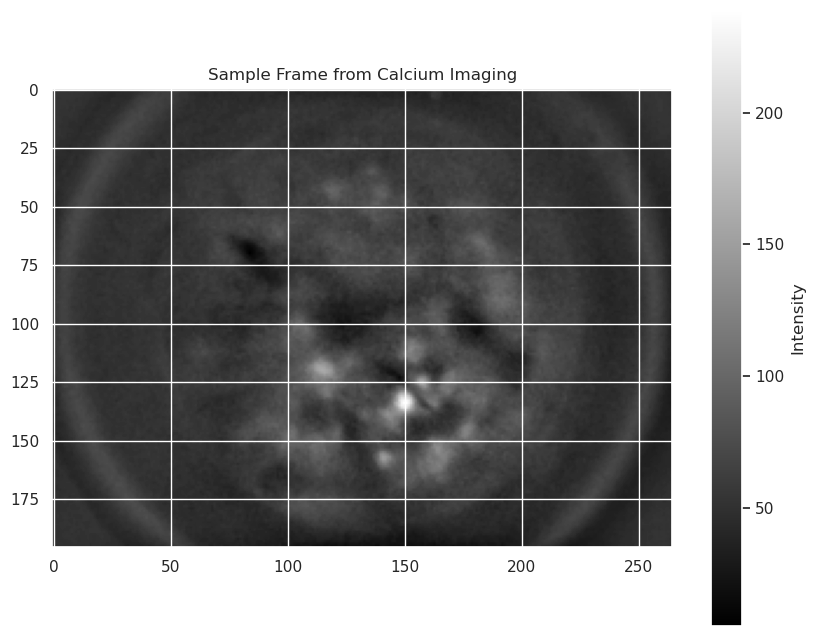

In [15]:
# Load a sample frame from the image series
try:
    # Get first frame
    sample_frame = image_series.data[0, :, :]
    
    # Display the sample frame
    plt.figure(figsize=(10, 8))
    plt.imshow(sample_frame, cmap='gray')
    plt.colorbar(label='Intensity')
    plt.title('Sample Frame from Calcium Imaging')
    plt.show()
    
except Exception as e:
    print(f"Error loading image frame: {e}")
    print("Note: Loading large image data from remote files may be slow.")

### Analyzing Calcium Fluorescence Traces

In [16]:
# Get the fluorescence data
fluorescence = nwb_calcium.processing["ophys"].data_interfaces["Fluorescence"]
roi_response_series = fluorescence.roi_response_series["RoiResponseSeries"]
F = roi_response_series.data[:]
t = np.arange(F.shape[0]) / roi_response_series.rate  # Time in seconds

# Select a smaller subset to make plotting faster
# Use downsampling to reduce the data size
downsample = max(1, int(F.shape[0] / 2000))  # Keep around 2000 timepoints
F_ds = F[::downsample, :]
t_ds = t[::downsample]

# % [markdown]
# Now we'll plot the fluorescence traces for a few randomly selected ROIs:

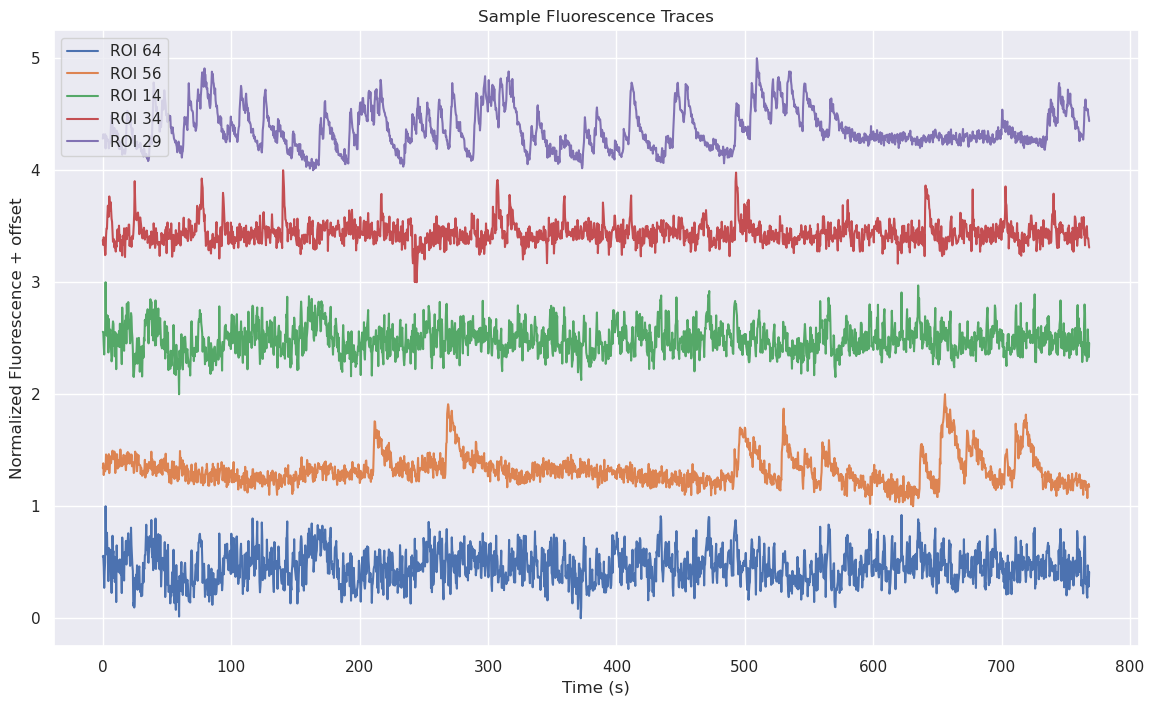

In [17]:
# Select a few random ROIs to plot
num_rois = F_ds.shape[1]
sample_rois = np.random.choice(range(num_rois), size=min(5, num_rois), replace=False)

plt.figure(figsize=(14, 8))
for i, roi_idx in enumerate(sample_rois):
    # Normalize the trace for better visualization
    trace = F_ds[:, roi_idx]
    trace_norm = (trace - np.min(trace)) / (np.max(trace) - np.min(trace) + 1e-6)
    plt.plot(t_ds, trace_norm + i, label=f'ROI {roi_idx}')
    
plt.xlabel('Time (s)')
plt.ylabel('Normalized Fluorescence + offset')
plt.title('Sample Fluorescence Traces')
plt.legend()
plt.grid(True)
plt.show()

### Calculating Mean Activity Across All ROIs

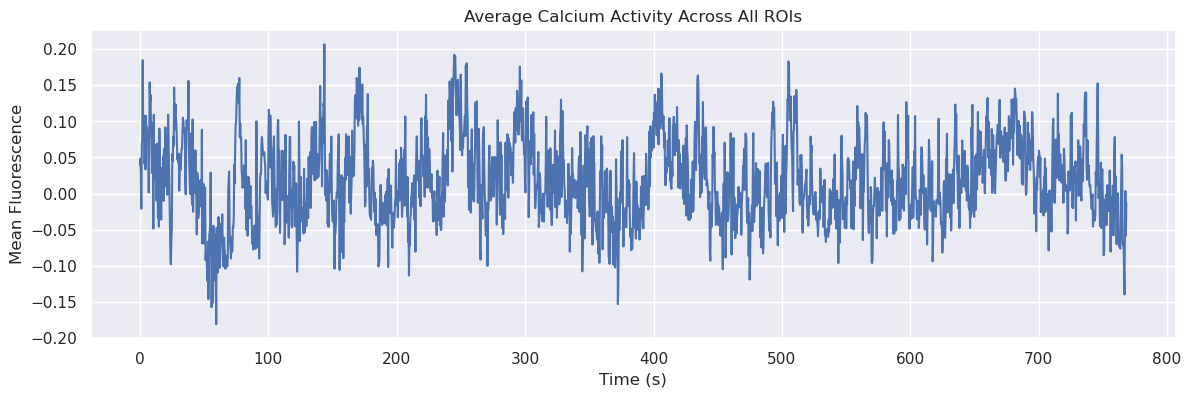

In [18]:
# Calculate mean activity over time
mean_activity = np.mean(F_ds, axis=1)

plt.figure(figsize=(14, 4))
plt.plot(t_ds, mean_activity)
plt.xlabel('Time (s)')
plt.ylabel('Mean Fluorescence')
plt.title('Average Calcium Activity Across All ROIs')
plt.grid(True)
plt.show()

### Activity Heatmap Across All ROIs

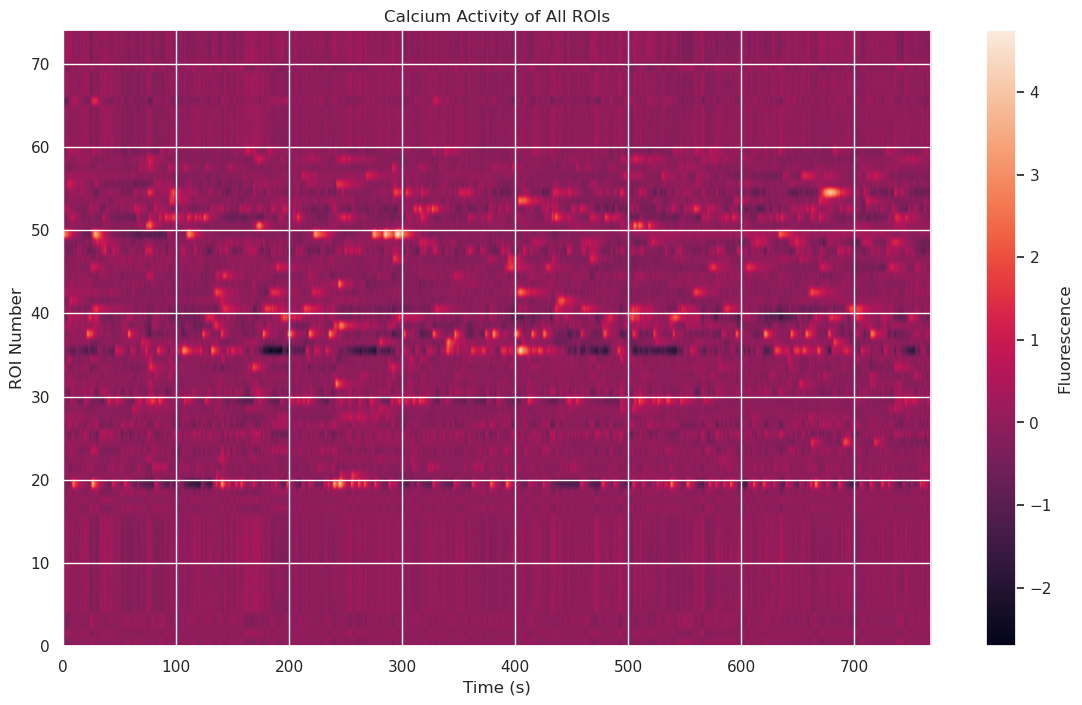

In [19]:
# Create a heatmap of all ROIs
plt.figure(figsize=(14, 8))
plt.imshow(F_ds.T, aspect='auto', origin='lower', 
           extent=[t_ds[0], t_ds[-1], 0, F_ds.shape[1]])
plt.colorbar(label='Fluorescence')
plt.xlabel('Time (s)')
plt.ylabel('ROI Number')
plt.title('Calcium Activity of All ROIs')
plt.show()

## Integration and Summary

In this notebook, we've explored two different types of data from Dandiset 001195, which investigates the role of Dorsal Raphe Dopamine neurons in loneliness-like states.

The patch-clamp electrophysiology data provides insights into the intrinsic cellular properties of neurons in the Dorsal Raphe Nucleus (DRN). We observed how these neurons respond to different current injections, with some stimuli eliciting action potentials. The current-voltage relationship reveals properties such as the input resistance of these neurons.

The calcium imaging data shows neuronal activity patterns in the Central Amygdala (CeA), which is one of the projection targets of the DRN dopamine neurons. We observed spontaneous activity across multiple neurons, with some showing coordinated patterns of activation.

## Future Directions

This analysis only scratches the surface of the rich dataset available. Future analyses could:

1. **Correlate calcium imaging activity with behavioral events**: The dataset includes behavioral videos that could be analyzed to correlate neuronal activity with specific behaviors.

2. **Compare socially isolated vs. group-housed animals**: The dataset includes recordings from both conditions, allowing for comparison of neural activity between these groups.

3. **Analyze optogenetic manipulation effects**: The metadata indicates optogenetic manipulations were performed, which could be analyzed to understand causal relationships.

4. **Perform spatial analysis of CeA activity**: More detailed analysis of the spatial organization of active neurons in the CeA could reveal functional sub-regions.

5. **Analyze electrophysiological properties across different neuron types**: More detailed analysis of the patch-clamp data could reveal differences in intrinsic properties between different types of neurons.